## Get and format ESH data

In [1]:
from __future__ import division

import os
import psycopg2
import numpy as np
import pandas as pd
from IPython.display import display, Markdown, HTML
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.pyplot import gca
import seaborn as sns

# connection credentials
HOST = os.environ.get("HOST_DAR")
USER = os.environ.get("USER_DAR")
PASSWORD = os.environ.get("PASSWORD_DAR")
DB = os.environ.get("DB_DAR")
GITHUB = os.environ.get("GITHUB")

# create cursor connection
myConnection = psycopg2.connect( host=HOST, user=USER, password=PASSWORD, database=DB)
cur = myConnection.cursor()

# functions to get specific tables
def get_districts():
    query = "select * from ps.districts"
    cur.execute(query)
    names = [x[0] for x in cur.description]
    rows = cur.fetchall()
    return pd.DataFrame(rows, columns=names)

def get_districts_bw_cost():
    query = "select * from ps.districts_bw_cost"
    cur.execute(query)
    names = [x[0] for x in cur.description]
    rows = cur.fetchall()
    return pd.DataFrame(rows, columns=names)

def get_districts_fit_for_analysis():
    query = "select * from ps.districts_fit_for_analysis"
    cur.execute(query)
    names = [x[0] for x in cur.description]
    rows = cur.fetchall()
    return pd.DataFrame(rows, columns=names)

def get_frn_num_bids():
    os.chdir(GITHUB + '''scripts/2019/prework_queries/')
    cur.execute(open('id9009_frn_num_bids_clean_districts.sql', "r").read())
    names = [ x[0] for x in cur.description]
    rows = cur.fetchall()
    return pd.DataFrame(rows, columns=names)

In [2]:
LATO_REG = fm.FontProperties()
LATO_REG.set_family('Lato')
#import math

def plot_linechart(df, metric, label_round, label_yaxis, label_title):
    fig, ax = plt.subplots()
    frame1 = plt.gca()
    
    xaxis = 'funding_year'
    yaxis = metric
    
    #white background and no frame except bottom
    sns.set_style('white', {'axes.linewidth': .5, 'axes.edgecolor':'#A1A1A1'})
    sns.despine(left=True, right=True)
    
    #format x axis font
    plt.xticks(df[xaxis])
    for label in ax.get_xticklabels() :
        label.set_fontproperties(LATO_REG)

    #format y axis font
    frame1.axes.get_yaxis().set_ticks([])
#     for label in ax.get_yticklabels() :
#         label.set_fontproperties(LATO_REG)
    plt.ylabel(str(label_yaxis), fontproperties=LATO_REG,size=14)

    #title
    plt.title(str(label_title), fontproperties=LATO_REG,size=17)
    
    for locale in ['Rural', 'Urban']:
        if locale == 'Rural':
            color = '#00529A'
        else:
            color = '#f26c23'
        
        plotdf = df[df['locale_grouped'] == locale][['funding_year', yaxis]]

        #plot line between all data points
        ax.plot(plotdf[xaxis], plotdf[yaxis], color=color, lw = 1.5, zorder=2)

        #plot markers for data points with no highlight
        plt.scatter(plotdf[xaxis], plotdf[yaxis], color=color, zorder=6, s=50)

        #add labels to markers for data points with no highlight
        for i in range(plotdf[xaxis].min(),plotdf[xaxis].max() + 1):
            if label_round == 0:
                ax.text(i-0.1, 1.065*plotdf[plotdf[xaxis] == i][yaxis], str(f"{int(plotdf[plotdf[xaxis] == i].reset_index()[yaxis][0]):,d}"), color=color, fontproperties=LATO_REG,size=10, ha='left', zorder=9)
            elif 'cost' in metric: 
                ax.text(i-0.1, 1.065*plotdf[plotdf[xaxis] == i][yaxis], '$' + str(round(plotdf[plotdf[xaxis] == i].reset_index()[yaxis][0],label_round)), color=color, fontproperties=LATO_REG,size=10, ha='left', zorder=9)
            else:
                ax.text(i-0.1, 1.01*plotdf[plotdf[xaxis] == i][yaxis], str(round(plotdf[plotdf[xaxis] == i].reset_index()[yaxis][0],label_round)), color=color, fontproperties=LATO_REG,size=10, ha='left', zorder=9)
                
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), labels=['Rural', 'Urban'])

In [3]:
def agg_2016_2019(df, metric, fun):
    result_df = pd.DataFrame()
    for year in [2016, 2019]:
        for locale in ['Rural', 'Urban']:
            data = df[(df.locale_grouped == locale) & (df.funding_year == year)][[metric]].apply(fun).item()
            result_df = pd.concat([result_df, pd.DataFrame({'funding_year': year, 'locale_grouped': locale, metric: data, 'metric': metric}, index=[0])], axis=0, ignore_index=True)
    return result_df

In [4]:
def display_table(df_all):
    df_all_stack = df_all.set_index(['locale_grouped','funding_year',]).stack().reset_index()
    df_all_stack = df_all_stack.rename(columns = {'level_2': 'metric', 0: 'value'})

    temp = df_all_stack.set_index(['locale_grouped','funding_year','metric']).unstack().reset_index(drop=True)
    temp.columns = temp.columns.droplevel()
    df_all_table = pd.concat([temp.iloc[0:4].reset_index(drop=True),temp.iloc[4:8].reset_index(drop=True)], axis=1)
    df_all_table['funding_year'] = [2016, 2017, 2018, 2019]

    df_all_table = df_all_table.set_index(['funding_year'])
    df_all_table.index.names = ['Funding Year']
    df_all_table = df_all_table[['ia_bw_mbps_total', 'ia_monthly_cost_total', 'ia_monthly_cost_per_mbps']]
    df_all_table = df_all_table.iloc[:, [0,2,4,1,3,5]]

    # further formatting
    df_all_table.columns = ['Broadband Speed', 'Monthly Fee', 'Monthly Fee per Mbps','Broadband Speed', 'Monthly Fee', 'Monthly Fee per Mbps']
    df_all_table.columns = pd.MultiIndex.from_product([['Rural Average', 'Urban Average'], df_all_table.columns[0:3]])

    th_props = [
      ('font-size', '12px'),
      ('text-align', 'center'),
      ('font-weight', 'bold'),
      ('color', '#6d6d6d'),
      ('background-color', '#f7f7f9')
      ]

    # Set CSS properties for td elements in dataframe
    td_props = [
      ('font-size', '11px'),
      ('text-align', 'center')
      ]

    # Set table styles
    styles = [
      dict(selector="th", props=th_props),
      dict(selector="td", props=td_props)
      ]

    return df_all_table.style.set_table_styles(styles).set_caption('Broadband Speeds and Costs Reported on E-rate Form 471 Funding Applications')

In [5]:
# get tables from dar prod database
df_d = get_districts()
df_fit = get_districts_fit_for_analysis()
df_bw_cost = get_districts_bw_cost()
df_bids = get_frn_num_bids()
cur.close()

In [6]:
# Select subset of columns
df_d_cols = ['district_id', 'state_code', 'funding_year','district_type','in_universe', 'locale']
df_fit_cols = ['district_id', 'funding_year', 'fit_for_ia']
df_bw_cost_cols = ['district_id', 'funding_year', 'ia_bw_mbps_total', 'ia_monthly_cost_total', 'ia_bandwidth_per_student_kbps', 'ia_monthly_cost_per_mbps']
df_bids_columns = ['district_id', 'funding_year', 'avg_li_num_bids_received']


# merge dataframes
merge_cols = ['district_id', 'funding_year']
df = df_d[df_d_cols].merge(df_fit[df_fit_cols],
                         on=merge_cols).merge(df_bw_cost[df_bw_cost_cols],
                         on=merge_cols).merge(df_bids[df_bids_columns],
                         on=merge_cols)

# filter the dataframe
df_filtered_ia = df[(df.in_universe==True) &
                 (df.district_type=='Traditional') &
                 (df.fit_for_ia==True)]

In [7]:
print(df_filtered_ia['funding_year'].value_counts())

2019    12428
2018    12357
2017    11872
2016    10690
Name: funding_year, dtype: int64


In [8]:
float_cols = ['ia_bw_mbps_total', 'ia_monthly_cost_total', 'avg_li_num_bids_received', 'ia_bandwidth_per_student_kbps', 'ia_monthly_cost_per_mbps']
df_filtered_ia[float_cols] = df_filtered_ia[float_cols].astype('float')

/Users/sierra/anaconda/envs/python37/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [9]:
df_filtered_ia['locale_grouped'] = np.where(np.logical_or(df_filtered_ia['locale']=='Urban',df_filtered_ia['locale']=='Suburban'),'Urban','Rural')

/Users/sierra/anaconda/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## Competition Lowers Broadband Prices (Funds for Learning [article](https://www.fundsforlearning.com/blog/2019/07/competition-lowers-broadband-prices?utm_source=iContact&utm_medium=email&utm_campaign=weekly-guidenotes&utm_content=Applicant+Guidenotes+Template)) using ESH Metrics

According to E-rate funding applications, the average<sup>1</sup> speed of broadband to school and library buildings has more than doubled since 2016, while the average price paid per megabit has dropped more than half. New options for broadband connectivity, including self-provisioned networks, and an increase in the number of available service providers are both factors driving this dramatic change.

In [10]:
upp_quantiles_bw = df_filtered_ia.groupby(['funding_year', 'locale_grouped'])[['funding_year', 'locale_grouped', 'ia_bw_mbps_total']].quantile(.95).drop('funding_year', axis=1)
print(upp_quantiles_bw)

0.95                         ia_bw_mbps_total
funding_year locale_grouped                  
2016         Rural                     2000.0
             Urban                    10000.0
2017         Rural                     2000.0
             Urban                    10000.0
2018         Rural                     3000.0
             Urban                    11000.0
2019         Rural                     5000.0
             Urban                    12580.0


#### Averages version (as in article -- using Total BW and Total Monthly Cost)

In [11]:
# filter out outliers
print(df_filtered_ia.shape)
idx = df_filtered_ia.apply(lambda row: row['ia_bw_mbps_total'] < upp_quantiles_bw.xs(key=[row['funding_year'],row['locale_grouped']]).item(), axis = 1)
df_no_bw_outlier = df_filtered_ia[idx]
print(df_no_bw_outlier.shape)

(47347, 13)
(44254, 13)


In [12]:
avg_bws = agg_2016_2019(df_no_bw_outlier, 'ia_bw_mbps_total', np.mean)

rural_ratio = round(avg_bws[(avg_bws.locale_grouped == 'Rural') & (avg_bws.funding_year == 2019)]['ia_bw_mbps_total'].item()/avg_bws[(avg_bws.locale_grouped == 'Rural') & (avg_bws.funding_year == 2016)]['ia_bw_mbps_total'].item(), 1)
urban_ratio = round(avg_bws[(avg_bws.locale_grouped == 'Urban') & (avg_bws.funding_year == 2019)]['ia_bw_mbps_total'].item()/avg_bws[(avg_bws.locale_grouped == 'Urban') & (avg_bws.funding_year == 2016)]['ia_bw_mbps_total'].item(), 1)

display(Markdown(rf"""In 2016, rural schools reported an average broadband connection speed of {int(avg_bws[(avg_bws.locale_grouped == 'Rural') & (avg_bws.funding_year == 2016)]['ia_bw_mbps_total'].item())} megabits per second (Mbps). For the same period, urban schools reported an average connection speed of {int(avg_bws[(avg_bws.locale_grouped == 'Urban') & (avg_bws.funding_year == 2016)]['ia_bw_mbps_total'].item())} Mbps. Now, in 2019, these speeds have more than doubled. Rural sites now have an average speed of {int(avg_bws[(avg_bws.locale_grouped == 'Rural') & (avg_bws.funding_year == 2019)]['ia_bw_mbps_total'].item())} Mbps, more than {rural_ratio} times faster than 2016. Urban sites now average {int(avg_bws[(avg_bws.locale_grouped == 'Urban') & (avg_bws.funding_year == 2019)]['ia_bw_mbps_total'].item())} Mbps, {urban_ratio} times faster than 2016."""))

In 2016, rural schools reported an average broadband connection speed of 381 megabits per second (Mbps). For the same period, urban schools reported an average connection speed of 1244 Mbps. Now, in 2019, these speeds have more than doubled. Rural sites now have an average speed of 836 Mbps, more than 2.2 times faster than 2016. Urban sites now average 3313 Mbps, 2.7 times faster than 2016.

In [13]:
df_bw = df_no_bw_outlier.groupby(['funding_year', 'locale_grouped'])['ia_bw_mbps_total'].mean().reset_index()

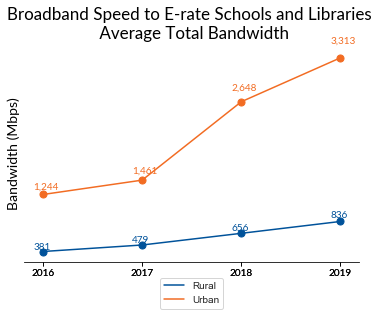

In [14]:
%matplotlib inline
plot_linechart(df_bw, 'ia_bw_mbps_total', 0, 'Bandwidth (Mbps)', 'Broadband Speed to E-rate Schools and Libraries \n Average Total Bandwidth')

In [15]:
avg_costs = agg_2016_2019(df_filtered_ia[df_filtered_ia.state_code != 'AK'], 'ia_monthly_cost_total', np.mean)
avg_costs['ia_monthly_cost_per_mbps'] = avg_costs['ia_monthly_cost_total']/avg_bws['ia_bw_mbps_total']
display(Markdown(rf"""Remarkably, this dramatic increase in bandwidth has cost applicants (and the E-rate program) very little money. The average monthly fee per megabit of download speed has dropped almost as much as the bandwidth being delivered has increased. In 2016, rural applicants paid an average of \\${str(round(avg_costs[(avg_costs.locale_grouped == 'Rural') & (avg_costs.funding_year == 2016)]['ia_monthly_cost_per_mbps'].item(),2))} monthly per Mbps of download speed. For urban applicants, the average fee was \\${str(round(avg_costs[(avg_costs.locale_grouped == 'Urban') & (avg_costs.funding_year == 2016)]['ia_monthly_cost_per_mbps'].item(),2))} per Mbps of download speed. Now, in 2019, the amount paid by rural and urban schools average \\${str(round(avg_costs[(avg_costs.locale_grouped == 'Rural') & (avg_costs.funding_year == 2019)]['ia_monthly_cost_per_mbps'].item(),2))} and \\${str(round(avg_costs[(avg_costs.locale_grouped == 'Urban') & (avg_costs.funding_year == 2019)]['ia_monthly_cost_per_mbps'].item(),2))} per Mbps, respectively."""))

Remarkably, this dramatic increase in bandwidth has cost applicants (and the E-rate program) very little money. The average monthly fee per megabit of download speed has dropped almost as much as the bandwidth being delivered has increased. In 2016, rural applicants paid an average of \\$8.31 monthly per Mbps of download speed. For urban applicants, the average fee was \\$4.55 per Mbps of download speed. Now, in 2019, the amount paid by rural and urban schools average \\$3.1 and \\$1.5 per Mbps, respectively.

In [16]:
df_cost = df_filtered_ia[df_filtered_ia.state_code != 'AK'].groupby(['funding_year', 'locale_grouped'])['ia_monthly_cost_total'].mean().reset_index()
df_cost['ia_monthly_cost_per_mbps'] = df_cost['ia_monthly_cost_total']/df_bw['ia_bw_mbps_total']

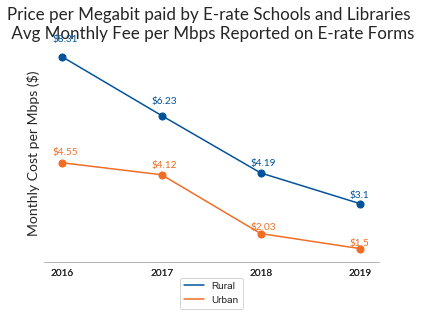

In [17]:
%matplotlib inline
plot_linechart(df_cost, 'ia_monthly_cost_per_mbps', 2, 'Monthly Cost per Mbps ($)', 'Price per Megabit paid by E-rate Schools and Libraries \n Avg Monthly Fee per Mbps Reported on E-rate Forms')

The net effect is that both rural and urban schools are receiving much faster connections for about the same money, or a little more, each month. The table below shows the average broadband speed, total monthly fee, and net monthly fee per Mbps for urban and rural schools.

In [18]:
df_all = df_cost.merge(df_bw, on=['funding_year','locale_grouped'])
display_table(df_all)

#### Median 'SotS' version (using BW per Student, Monthly Cost per Mbps)

In [19]:
med_bws = agg_2016_2019(df_filtered_ia, 'ia_bandwidth_per_student_kbps', np.median)

rural_ratio = round(med_bws[(med_bws.locale_grouped == 'Rural') & (med_bws.funding_year == 2019)]['ia_bandwidth_per_student_kbps'].item()/med_bws[(med_bws.locale_grouped == 'Rural') & (med_bws.funding_year == 2016)]['ia_bandwidth_per_student_kbps'].item(), 1)
urban_ratio = round(med_bws[(med_bws.locale_grouped == 'Urban') & (med_bws.funding_year == 2019)]['ia_bandwidth_per_student_kbps'].item()/med_bws[(med_bws.locale_grouped == 'Urban') & (med_bws.funding_year == 2016)]['ia_bandwidth_per_student_kbps'].item(), 1)

display(Markdown(rf"""In 2016, rural schools reported a median broadband connection speed of {int(med_bws[(med_bws.locale_grouped == 'Rural') & (med_bws.funding_year == 2016)]['ia_bandwidth_per_student_kbps'].item())} kilobits per second per student (kbps). For the same period, urban schools reported a median connection speed of {int(med_bws[(med_bws.locale_grouped == 'Urban') & (med_bws.funding_year == 2016)]['ia_bandwidth_per_student_kbps'].item())} kbps. Now, in 2019, these speeds have more than doubled. Rural sites now have a median speed of {int(med_bws[(med_bws.locale_grouped == 'Rural') & (avg_bws.funding_year == 2019)]['ia_bandwidth_per_student_kbps'].item())} kbps, more than {rural_ratio} times faster than 2016. Urban sites now have a median of {int(med_bws[(med_bws.locale_grouped == 'Urban') & (med_bws.funding_year == 2019)]['ia_bandwidth_per_student_kbps'].item())} kbps, {urban_ratio} times faster than 2016."""))

In 2016, rural schools reported a median broadband connection speed of 293 kilobits per second per student (kbps). For the same period, urban schools reported a median connection speed of 215 kbps. Now, in 2019, these speeds have more than doubled. Rural sites now have a median speed of 789 kbps, more than 2.7 times faster than 2016. Urban sites now have a median of 471 kbps, 2.2 times faster than 2016.

In [20]:
df_bw = df_filtered_ia.groupby(['funding_year', 'locale_grouped'])['ia_bandwidth_per_student_kbps'].median().reset_index()

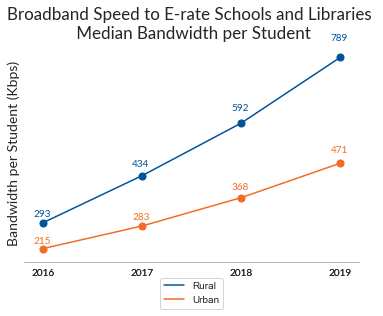

In [21]:
%matplotlib inline
plot_linechart(df_bw, 'ia_bandwidth_per_student_kbps', 0, 'Bandwidth per Student (Kbps)', 'Broadband Speed to E-rate Schools and Libraries \n Median Bandwidth per Student')

In [22]:
med_costs = agg_2016_2019(df_filtered_ia[df_filtered_ia.state_code != 'AK'], 'ia_monthly_cost_per_mbps', np.median)
display(Markdown(rf"""Remarkably, this dramatic increase in bandwidth has cost applicants (and the E-rate program) very little money. The median monthly fee per megabit of download speed has dropped almost as much as the bandwidth being delivered has increased. In 2016, rural applicants paid a median of \\${str(round(med_costs[(med_costs.locale_grouped == 'Rural') & (med_costs.funding_year == 2016)]['ia_monthly_cost_per_mbps'].item(),2))} monthly per Mbps of download speed. For urban applicants, the median fee was \\${str(round(med_costs[(med_costs.locale_grouped == 'Urban') & (med_costs.funding_year == 2016)]['ia_monthly_cost_per_mbps'].item(),2))} per Mbps of download speed. Now, in 2019, the median amount paid by rural and urban schools is \\${str(round(med_costs[(med_costs.locale_grouped == 'Rural') & (med_costs.funding_year == 2019)]['ia_monthly_cost_per_mbps'].item(),2))} and \\${str(round(med_costs[(med_costs.locale_grouped == 'Urban') & (med_costs.funding_year == 2019)]['ia_monthly_cost_per_mbps'].item(),2))} per Mbps, respectively."""))

Remarkably, this dramatic increase in bandwidth has cost applicants (and the E-rate program) very little money. The median monthly fee per megabit of download speed has dropped almost as much as the bandwidth being delivered has increased. In 2016, rural applicants paid a median of \\$9.44 monthly per Mbps of download speed. For urban applicants, the median fee was \\$4.05 per Mbps of download speed. Now, in 2019, the median amount paid by rural and urban schools is \\$2.75 and \\$1.5 per Mbps, respectively.

In [23]:
df_costmbps_med = df_filtered_ia[df_filtered_ia.state_code != 'AK'].groupby(['funding_year', 'locale_grouped'])['ia_monthly_cost_per_mbps'].median().reset_index()
df_cost_med = df_filtered_ia[df_filtered_ia.state_code != 'AK'].groupby(['funding_year', 'locale_grouped'])['ia_monthly_cost_total'].median().reset_index()

In [24]:
df_cost = df_costmbps_med.merge(df_cost_med[['funding_year', 'locale_grouped', 'ia_monthly_cost_total']], on=['funding_year', 'locale_grouped'])

In [25]:
df_cost_plot = df_cost.groupby(['funding_year', 'locale_grouped'])['ia_monthly_cost_per_mbps'].median().reset_index()

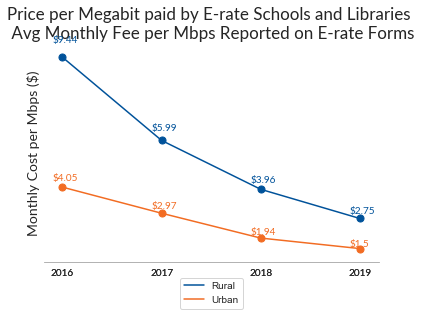

In [26]:
%matplotlib inline
plot_linechart(df_cost_plot, 'ia_monthly_cost_per_mbps', 2, 'Monthly Cost per Mbps ($)', 'Price per Megabit paid by E-rate Schools and Libraries \n Avg Monthly Fee per Mbps Reported on E-rate Forms')

The net effect is that both rural and urban schools are receiving much faster connections for about the same money, or a little more, each month. The table below shows the median broadband speed, total monthly fee, and net monthly fee per Mbps for urban and rural schools.

In [27]:
df_all = df_cost.merge(df_bw, on=['funding_year','locale_grouped']).rename(columns={'ia_bandwidth_per_student_kbps':'ia_bw_mbps_total'})
display_table(df_all)

### Increased Competition Drives Improvements 

Competition appears to be a significant driver behind the faster connection speeds and more cost-effective pricing.

In [28]:
upp_quantiles_bids = df_filtered_ia.groupby(['funding_year'])[['funding_year','avg_li_num_bids_received']].quantile(.995).drop('funding_year', axis=1)
print(upp_quantiles_bids)

0.995         avg_li_num_bids_received
funding_year                          
2016                         16.351667
2017                         20.980392
2018                         21.357143
2019                         22.148148


In [29]:
print(df_filtered_ia.shape)
idx = df_filtered_ia.apply(lambda row: row['avg_li_num_bids_received'] < upp_quantiles_bids.xs(key=row['funding_year']).item(), axis = 1)
df_no_bids_outlier = df_filtered_ia[idx]
print(df_no_bids_outlier.shape)

(47347, 13)
(46963, 13)


In [30]:
avg_bids = df_no_bids_outlier.groupby('funding_year')['avg_li_num_bids_received'].mean().reset_index()

In [31]:
avg_bids_2019 = round(avg_bids[avg_bids.funding_year == 2019]['avg_li_num_bids_received'].item(),2)
avg_bids_2016 = round(avg_bids[avg_bids.funding_year == 2016]['avg_li_num_bids_received'].item(),2)

avg_bids_2016_2019_increase = int(((avg_bids_2019 - avg_bids_2016)/avg_bids_2016)*100)

In [32]:
display(Markdown(rf"""This has helped foster an environment that encourages more vendors to submit bids to provide services to schools and libraries. Since 2016, the average number of bids received for Category One data services has increased {avg_bids_2016_2019_increase}%. In 2016, applicants received an average of {avg_bids_2016} vendors bids for their data services. In 2019, applicants received an average of {avg_bids_2019} vendor bids for their data services. Importantly, both urban and rural applicants have benefited from an increase in competition for their business."""))

This has helped foster an environment that encourages more vendors to submit bids to provide services to schools and libraries. Since 2016, the average number of bids received for Category One data services has increased 23%. In 2016, applicants received an average of 2.92 vendors bids for their data services. In 2019, applicants received an average of 3.61 vendor bids for their data services. Importantly, both urban and rural applicants have benefited from an increase in competition for their business.

In [33]:
df_bids = df_no_bids_outlier.groupby(['funding_year', 'locale_grouped'])['avg_li_num_bids_received'].mean().reset_index()

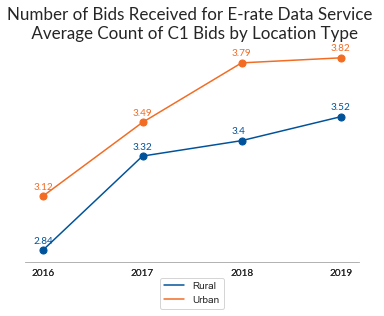

In [34]:
%matplotlib inline
plot_linechart(df_bids, 'avg_li_num_bids_received', 2, '', 'Number of Bids Received for E-rate Data Service \n Average Count of C1 Bids by Location Type')

In [35]:
df_bids_table = pd.DataFrame({'Funding Year': [2016,2017,2018,2019],
                             'Rural': df_bids[df_bids.locale_grouped == 'Rural'][['funding_year','avg_li_num_bids_received']].iloc[:,1].reset_index(drop=True),
                             'Urban': df_bids[df_bids.locale_grouped == 'Urban'][['funding_year','avg_li_num_bids_received']].iloc[:,1].reset_index(drop=True),
                             'Overall': avg_bids['avg_li_num_bids_received']}, index=range(4)).round(2)

In [36]:
th_props = [
  ('font-size', '12px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', '#6d6d6d'),
  ('background-color', '#f7f7f9')
  ]

# Set CSS properties for td elements in dataframe
td_props = [
  ('font-size', '11px'),
  ('text-align', 'center')
  ]

# Set table styles
styles = [
  dict(selector="th", props=th_props),
  dict(selector="td", props=td_props)
  ]

df_bids_table.style.set_table_styles(styles).set_caption('Average Count of C1 Bids by Location Type').hide_index()

Funding Year,Rural,Urban,Overall
2016,2.84,3.12,2.92
2017,3.32,3.49,3.37
2018,3.4,3.79,3.51
2019,3.52,3.82,3.61


### About the Calculations
* The underlying data for all metrics is at the **district** level. Used _clean for IA_ districts in each year (independently)
* The data labels on the graphs may be slightly less than the actual numbers reported in the text and tables due to rounding capabilities (truncation is applied)
* <sup>1</sup>'Averages version': removed top 5% district outliers for Total BW for each year and locale
* AK districts were removed for all cost metrics
* Bids are defined at the E-rate funding request level, so took the _average_ count of C1 bids for each district among all funding request(s) they receive services from. Removed the top 0.05% district outliers for this metric for each year.